In [263]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [40]:
class Activations():
    '''
    A collection of activation functions.
    All activation functions are vector friendly.
    '''
    
    @staticmethod
    def read_function(name):
        return getattr(Activations, str(name), "InvalidFunction")
    
    @staticmethod
    def InvalidFunction(*arg):
        raise Exception("Invalid activation function")
    
    @staticmethod
    def linear(inp, derivative = False):
        out = np.array(inp)
        if derivative:
            out = np.ones(out.shape)
        return out
    
    @staticmethod
    def logistic(inp, derivative = False):
        out = np.array(inp)
        if derivative:
            n_dev = Activations.logistic(out, False)
            out = (1 - n_dev) * n_dev
        else:
            out = 1.0/(1 + np.exp(-1 * inp))
        return out
    
    @staticmethod
    def relu(inp, derivative = False):
        out = np.array(inp)
        if derivative:
            out = np.where(out >= 0, 1, 0)
        else:
            out = np.where(out >=0, out, 0)
        return out
    
    @staticmethod
    def leaky_relu(inp, derivative = False, leak = 0.01):
        out = np.array(inp)
        if derivative:
            out = np.where(out >=0, 1, leak)
        else:
            out = np.where(out >=0, out, leak * out)
        return out

In [269]:
class CollectionOfFunctions():
    '''
    A generic collection of functions that has mostly static methods,
    and the capability to get attribute corresponding to a string
    '''

    @staticmethod
    def read_function(name):
        ''''
        returns the method corresponding to the name.
        '''
        return getattr(Activations, str(name), "InvalidFunction")
    
    @staticmethod
    def InvalidFunction(*arg):
        '''
        raises an exception if the activation function requested does not exist.
        '''
        raise Exception("Invalid activation function")

class Activations(CollectionOfFunctions):
    '''
    A collection of activation functions written using numpy functions.
    Included activation functions are linear, logistic (sigmoid), relu,
    and leaky relu. All methods are static, with the capability of 
    calculating their derivatives.
    '''
  
    @staticmethod
    def linear(inp, derivative = False):
        '''
        returns image of function f(x) = x
        '''
        out = np.array(inp)
        if derivative:
            out = np.ones(out.shape)
        return out
    
    @staticmethod
    def logistic(inp, derivative = False):
        '''
        returns the sigmoid of the input
        '''
        out = np.array(inp)
        if derivative:
            n_dev = Activations.logistic(out, False)
            out = (1 - n_dev) * n_dev
        else:
            out = 1.0/(1 + np.exp(-1 * inp))
        return out
    
    @staticmethod
    def relu(inp, derivative = False):
        '''
        returns the image of the function f(x) = max(0, x) 
        '''
        out = np.array(inp)
        if derivative:
            out = np.where(out >= 0, 1, 0)
        else:
            out = np.where(out >=0, out, 0)
        return out
    
    @staticmethod
    def leaky_relu(inp, derivative = False, leak = 0.01):
        '''
        returns a modified computation of relu, where negative input yields
        a smaller output magnitude than that of when input is positve.
        the value of leak is a hyperparameter which may be tuned. 
        '''
        out = np.array(inp)
        if derivative:
            out = np.where(out >=0, 1, leak)
        else:
            out = np.where(out >=0, out, leak * out)
        return out

class Losses(CollectionOfFunctions):
    '''
    A collection of vector friendly loss functions.
    Included loss functions are mean squared error, and binary crosss entropy.
    '''

    @staticmethod
    def mse(expected, outputs):
        '''
        Mean Square Error loss function
        '''
        expected = np.array(expected)
        outputs = np.array(outputs)
        return 0.5 * (expected - outputs) ** 2

    @staticmethod
    def binary_cross_entropy(expected, outputs, derivative=False):
        '''
        Cross-entropy loss function
        '''
        expected = np.array(expected)
        outputs = np.array(outputs)
        # return -1 * expected * np.log(outputs) - (1 - expected) * np.log(1 - outputs)
        return metrics.log_loss(expected, outputs)

In [271]:
Activations.InvalidFunction()

Exception: Invalid activation function

In [250]:
class NeuralNetwork():
    
    # parameters and activations
    net_params = dict()
    activations = list()
    num_layers = 0
    
    def __init__(self, structure):
        self.create_network(structure)
    
    def create_network(self, structure):
        '''
        capability for only dense layers
        '''
        
        # ensure that the first layer is an input layer
        try:
            assert(structure[0]["type"] == "input")
        except:
            raise Exception("The first layer needs to be an input layer")
        
        self.num_layers = len(structure) - 1
        prev_units = int(structure[0]["units"])
        for i, layer in enumerate(structure[1: ]):
            # weight matrix at a layer has (i - 1 x i) shape 
            current_units = layer["units"]
            
            # initialize weight and bias paramters
            self.net_params["w" + str(i + 1)] = np.zeros((prev_units, current_units))
            self.net_params["b" + str(i + 1)] = None
            
            # add a bias parameter only if specified
            if layer["bias"]:
                self.net_params["b" + str(i + 1)] = np.zeros((1, layer["units"]))
            
            # store activation function in attribute and continue loop
            self.activations.append(layer["activation_function"])
            prev_units = current_units
        
        return self
    
    def show_model(self):
        for name, arr in self.net_params.items():
            print("Shape of ", name, ": ", arr.shape)
            
    def initialize_weights(self, leak = 0.01):
        '''
        Using Kaiming initialization
        '''
        for i in range(1, self.num_layers + 1):
            # leak only exists in leaky relu
            if self.activations[i - 1] != "leaky_relu":
                leak = 0
            
            # using Kaiming initialization only on weights and not biases
            param = self.net_params["w" + str(i)]
            self.net_params["w" + str(i)] = np.sqrt(2/((1 + leak * leak)\
                                            * param.shape[0])) * np.random.randn(*param.shape)
            
            # using random initialization on bias if it is included
            param = self.net_params["b" + str(i)]
            if param is not None:
                self.net_params["b" + str(i)] = np.random.randn(*param.shape)
            
        return self
    
    def forward_prop(self, inp):
        # sanity check
        inp = np.array(inp)
        
        # propogate
        for l in range(1, self.num_layers + 1):
            bias = self.net_params["b" + str(l)]
            if bias is None:
                self.net_params["z" + str(l)] = np.matmul(inp, self.net_params["w" + str(l)])
            else:
                self.net_params["z" + str(l)] = np.matmul(inp, self.net_params["w" + str(l)]) + bias
            act = Activations.read_function(self.activations[l - 1])
            self.net_params["a" + str(l)] = act(self.net_params["z" + str(l)])
            inp = self.net_params["a" + str(l)]
        
        return self
    
    def back_prop(self, inp, out, loss_name):
        # sanity check
        inp = np.array(inp)
        out = np.array(out)
        
        # for last layer
        # only two types of losses are considered
        # ll is the string casted version of number of layers
        ll = str(self.num_layers)
        if loss_name == "mse":
            self.net_params["delta" + ll] = np.multiply(self.net_params["a" + ll] - out,\
                                            Activations.read_function(self.activations[-1])\
                                            (self.net_params["z" + ll], derivative = True))
        elif loss_name == "binary_cross_entropy":
            self.net_params["delta" + ll] = self.net_params["a" + ll] - out
        else:
            raise Exception("Only two types of loss functions are supported: MSE and BCE")
        
        # for every other layer except the last
        for l in reversed(range(1, self.num_layers)):
            self.net_params["delta" + str(l)] = np.multiply(Activations.read_function(self.activations[l - 1])\
                                                (self.net_params["z" + str(l)], derivative = True),\
                                                np.matmul(self.net_params["delta" + str(l + 1)],\
                                                np.transpose(self.net_params["w" + str(l + 1)]),))
        return self
    
    def update_weights(self, inp, l_rate):
        # update for the first layer
        self.net_params["dw1"] = np.matmul(np.transpose(inp), self.net_params["delta1"])
        if self.net_params["b1"] is not None:
            self.net_params["db1"] = np.sum(self.net_params["delta1"], axis = 0, keepdims = True)
        
        # calculate gradient of weights
        for l in range(2, self.num_layers + 1):
            self.net_params["dw" + str(l)] = np.matmul(np.transpose(self.net_params["a" + str(l - 1)]),\
                                             self.net_params["delta" + str(l)])
            if self.net_params["b" + str(l)] is not None:
                self.net_params["db" + str(l)] = np.sum(self.net_params["delta" + str(l)], axis = 0, keepdims = True)
                
        # update weights
        for l in range(1, self.num_layers + 1):
            self.net_params["w" + str(l)] -= l_rate/inp.shape[0] * self.net_params["dw" + str(l)]
            if self.net_params["b" + str(l)] is not None:
                self.net_params["b" + str(l)] -= l_rate/inp.shape[0] * self.net_params["db" + str(l)]
                
        return self
    
    def predict(self, inp):
        '''
        predicts output
        '''
        self.forward_prop(inp)
        result = np.round(self.net_params["a" + str(self.num_layers)])
        return result
    
    def calc_loss(self, out, loss_func):
        return np.sum(Losses.read_function(loss_func)(out, self.net_params["a" + str(self.num_layers)]))
    
    def accuracy(self, inp, out):
        '''
        returns accuracy as a percentage
        '''
        return sum(self.predict(inp) == out)[0]/out.shape[0] * 100
    
    def train(self, X, Y, n_epochs = 500, batch_size = 16, loss_func = "mse", l_rate = 0.001, rand_scale = 0.1, verbose = True):
        # augmenting data
        X = np.concatenate((X, augment_data(X, rand_scale)))
        Y = np.concatenate((Y, Y))
        
        self.initialize_weights()
        
        num_batches = int(np.ceil(X.shape[0]/batch_size))
        
        for epoch in range(n_epochs):
            
            self.forward_prop(X)
            if verbose:
                print("Loss after ", epoch, " epoch(s): ", self.calc_loss(Y, loss_func),\
                      ", Accuracy: ", self.accuracy(X, Y))
            
            for i in range(num_batches):
                x = X[i * batch_size: (i + 1) * batch_size, :]
                y = Y[i * batch_size: (i + 1) * batch_size, :]
                
                nn.forward_prop(x)
                nn.back_prop(x, y, loss_func)
                nn.update_weights(x, l_rate)
        
        self.forward_prop(X)
        print("Final loss: ", self.calc_loss(Y, loss_func), "Final accuracy: ", self.accuracy(X, Y))
        return self
                

In [251]:
structure = [{'type': 'input', 'units': 2},
            {'type': 'dense', 'units': 12, 'activation_function': 'leaky_relu', 'bias': True},
            {'type': 'dense', 'units': 12, 'activation_function': 'leaky_relu', 'bias': True},
            {'type': 'dense', 'units': 1, 'activation_function': 'logistic', 'bias': True}]

Loss after  0  epoch(s):  2.6750793642772646 , Accuracy:  50.0
Loss after  1  epoch(s):  0.9562522486332583 , Accuracy:  44.375
Loss after  2  epoch(s):  0.7873867768744078 , Accuracy:  48.75
Loss after  3  epoch(s):  0.778651567744058 , Accuracy:  48.75
Loss after  4  epoch(s):  0.7693554294307727 , Accuracy:  48.125
Loss after  5  epoch(s):  0.7609544215118302 , Accuracy:  48.125
Loss after  6  epoch(s):  0.7548363613263613 , Accuracy:  49.375
Loss after  7  epoch(s):  0.7503553288577705 , Accuracy:  49.375
Loss after  8  epoch(s):  0.7469085951669763 , Accuracy:  50.625
Loss after  9  epoch(s):  0.7442399457175497 , Accuracy:  50.625
Loss after  10  epoch(s):  0.7422625719809929 , Accuracy:  50.625
Loss after  11  epoch(s):  0.7407614363823937 , Accuracy:  50.625
Loss after  12  epoch(s):  0.7395994325938623 , Accuracy:  50.625
Loss after  13  epoch(s):  0.7386852789152434 , Accuracy:  50.625
Loss after  14  epoch(s):  0.7378813972518028 , Accuracy:  49.375
Loss after  15  epoch(s):

Loss after  146  epoch(s):  0.6621316109796181 , Accuracy:  58.75
Loss after  147  epoch(s):  0.6614805174248678 , Accuracy:  58.75
Loss after  148  epoch(s):  0.6607183123063596 , Accuracy:  58.75
Loss after  149  epoch(s):  0.6600900253071803 , Accuracy:  58.75
Loss after  150  epoch(s):  0.6594764990933811 , Accuracy:  58.75
Loss after  151  epoch(s):  0.658872467263737 , Accuracy:  59.375
Loss after  152  epoch(s):  0.6582673161559786 , Accuracy:  59.375
Loss after  153  epoch(s):  0.6576593973561087 , Accuracy:  59.375
Loss after  154  epoch(s):  0.6570480258482914 , Accuracy:  59.375
Loss after  155  epoch(s):  0.6564333654624182 , Accuracy:  59.375
Loss after  156  epoch(s):  0.6562943165253834 , Accuracy:  59.375
Loss after  157  epoch(s):  0.6554896066678972 , Accuracy:  59.375
Loss after  158  epoch(s):  0.6551521073297325 , Accuracy:  59.375
Loss after  159  epoch(s):  0.6542970851170604 , Accuracy:  59.375
Loss after  160  epoch(s):  0.6539473136626921 , Accuracy:  59.375
L

Loss after  288  epoch(s):  0.5625263512447363 , Accuracy:  67.5
Loss after  289  epoch(s):  0.5613968877267171 , Accuracy:  68.75
Loss after  290  epoch(s):  0.5605441654003572 , Accuracy:  69.375
Loss after  291  epoch(s):  0.5595730117718233 , Accuracy:  69.375
Loss after  292  epoch(s):  0.5587390662590552 , Accuracy:  69.375
Loss after  293  epoch(s):  0.5579014689405015 , Accuracy:  69.375
Loss after  294  epoch(s):  0.5560698921671829 , Accuracy:  69.375
Loss after  295  epoch(s):  0.5561541927493726 , Accuracy:  69.375
Loss after  296  epoch(s):  0.5554780820526898 , Accuracy:  69.375
Loss after  297  epoch(s):  0.5547034849005658 , Accuracy:  69.375
Loss after  298  epoch(s):  0.554052316843174 , Accuracy:  69.375
Loss after  299  epoch(s):  0.5533011564833638 , Accuracy:  69.375
Loss after  300  epoch(s):  0.5525836519327783 , Accuracy:  69.375
Loss after  301  epoch(s):  0.5518501082121438 , Accuracy:  69.375
Loss after  302  epoch(s):  0.5510771694472792 , Accuracy:  69.375

Loss after  431  epoch(s):  0.46269915286112007 , Accuracy:  76.875
Loss after  432  epoch(s):  0.4617093194520135 , Accuracy:  76.875
Loss after  433  epoch(s):  0.4613983079273899 , Accuracy:  76.875
Loss after  434  epoch(s):  0.4603135556490227 , Accuracy:  76.875
Loss after  435  epoch(s):  0.45985926781028114 , Accuracy:  76.875
Loss after  436  epoch(s):  0.45894389631688454 , Accuracy:  76.875
Loss after  437  epoch(s):  0.45831095061142674 , Accuracy:  76.875
Loss after  438  epoch(s):  0.4580651330947211 , Accuracy:  76.875
Loss after  439  epoch(s):  0.4570305500724469 , Accuracy:  77.5
Loss after  440  epoch(s):  0.45673128256710943 , Accuracy:  77.5
Loss after  441  epoch(s):  0.45571116339209167 , Accuracy:  77.5
Loss after  442  epoch(s):  0.45504408675023045 , Accuracy:  77.5
Loss after  443  epoch(s):  0.4547439079051399 , Accuracy:  77.5
Loss after  444  epoch(s):  0.4539007808521706 , Accuracy:  77.5
Loss after  445  epoch(s):  0.45331442423928553 , Accuracy:  77.5
L

Loss after  570  epoch(s):  0.39635488352276843 , Accuracy:  82.5
Loss after  571  epoch(s):  0.39547685567373936 , Accuracy:  82.5
Loss after  572  epoch(s):  0.39508820027500235 , Accuracy:  82.5
Loss after  573  epoch(s):  0.3952806200723027 , Accuracy:  82.5
Loss after  574  epoch(s):  0.3941972443052447 , Accuracy:  82.5
Loss after  575  epoch(s):  0.39381748389361865 , Accuracy:  82.5
Loss after  576  epoch(s):  0.3940143771905288 , Accuracy:  82.5
Loss after  577  epoch(s):  0.3931240246973195 , Accuracy:  82.5
Loss after  578  epoch(s):  0.3927428778879998 , Accuracy:  82.5
Loss after  579  epoch(s):  0.392217575440522 , Accuracy:  82.5
Loss after  580  epoch(s):  0.39092548218477935 , Accuracy:  82.5
Loss after  581  epoch(s):  0.3899870352591207 , Accuracy:  82.5
Loss after  582  epoch(s):  0.3895497840551757 , Accuracy:  82.5
Loss after  583  epoch(s):  0.3890239426794067 , Accuracy:  82.5
Loss after  584  epoch(s):  0.38976383717644536 , Accuracy:  82.5
Loss after  585  epo

Loss after  693  epoch(s):  0.3531832665296474 , Accuracy:  84.375
Loss after  694  epoch(s):  0.35285399920802807 , Accuracy:  84.375
Loss after  695  epoch(s):  0.3524083226495209 , Accuracy:  84.375
Loss after  696  epoch(s):  0.3521350583348051 , Accuracy:  84.375
Loss after  697  epoch(s):  0.3517933211722078 , Accuracy:  84.375
Loss after  698  epoch(s):  0.35145941271188263 , Accuracy:  84.375
Loss after  699  epoch(s):  0.35105133373195124 , Accuracy:  84.375
Loss after  700  epoch(s):  0.35076926731192143 , Accuracy:  84.375
Loss after  701  epoch(s):  0.3504636951397795 , Accuracy:  84.375
Loss after  702  epoch(s):  0.3501386420038106 , Accuracy:  84.375
Loss after  703  epoch(s):  0.34983800858994285 , Accuracy:  84.375
Loss after  704  epoch(s):  0.3494275001337755 , Accuracy:  84.375
Loss after  705  epoch(s):  0.34918749670704885 , Accuracy:  84.375
Loss after  706  epoch(s):  0.3509009753455036 , Accuracy:  84.375
Loss after  707  epoch(s):  0.35063301555509074 , Accura

Loss after  834  epoch(s):  0.3250104175883714 , Accuracy:  86.25
Loss after  835  epoch(s):  0.32487084196046323 , Accuracy:  86.25
Loss after  836  epoch(s):  0.3247283515603674 , Accuracy:  86.25
Loss after  837  epoch(s):  0.32456734570097157 , Accuracy:  86.25
Loss after  838  epoch(s):  0.32284215409040584 , Accuracy:  86.25
Loss after  839  epoch(s):  0.3242806090828231 , Accuracy:  86.25
Loss after  840  epoch(s):  0.3241423764291177 , Accuracy:  86.25
Loss after  841  epoch(s):  0.3239822176178187 , Accuracy:  86.25
Loss after  842  epoch(s):  0.32384646511920856 , Accuracy:  86.25
Loss after  843  epoch(s):  0.32370792758083217 , Accuracy:  86.25
Loss after  844  epoch(s):  0.32356989259725516 , Accuracy:  86.25
Loss after  845  epoch(s):  0.32341351282558534 , Accuracy:  86.25
Loss after  846  epoch(s):  0.3217149592731291 , Accuracy:  86.25
Loss after  847  epoch(s):  0.323136713056326 , Accuracy:  86.25
Loss after  848  epoch(s):  0.32300315288931497 , Accuracy:  86.25
Los

Loss after  975  epoch(s):  0.30823518802039274 , Accuracy:  86.25
Loss after  976  epoch(s):  0.3094122760923936 , Accuracy:  86.25
Loss after  977  epoch(s):  0.30933081369641685 , Accuracy:  86.25
Loss after  978  epoch(s):  0.30933305893750773 , Accuracy:  86.25
Loss after  979  epoch(s):  0.30922396088679954 , Accuracy:  86.25
Loss after  980  epoch(s):  0.30913489689399015 , Accuracy:  86.25
Loss after  981  epoch(s):  0.30904825435216415 , Accuracy:  86.25
Loss after  982  epoch(s):  0.3089634682730365 , Accuracy:  86.25
Loss after  983  epoch(s):  0.3076314793260573 , Accuracy:  86.25
Loss after  984  epoch(s):  0.3087950900221496 , Accuracy:  86.25
Loss after  985  epoch(s):  0.3087150688504322 , Accuracy:  86.25
Loss after  986  epoch(s):  0.3086335797878833 , Accuracy:  86.25
Loss after  987  epoch(s):  0.30865430010700057 , Accuracy:  86.25
Loss after  988  epoch(s):  0.30854417016841607 , Accuracy:  86.25
Loss after  989  epoch(s):  0.3072134913004444 , Accuracy:  86.25
Lo

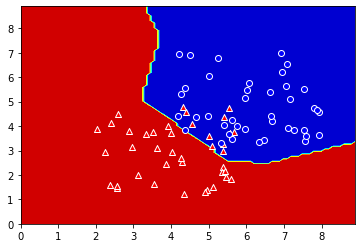

In [268]:
nn = NeuralNetwork(structure)
from time import time

tic = time()
nn.train(X, Y, n_epochs=1000, batch_size=8, loss_func = "binary_cross_entropy")
print(time() - tic)

xx, yy = np.meshgrid(np.arange(0, 9, 0.1), np.arange(0, 9, 0.1))

X_vis = np.c_[xx.ravel(), yy.ravel()]

h = nn.predict(X_vis)
h = np.array(h) >= 0.5
h = np.reshape(h, (len(xx), len(yy)))

idx0 = [i for i, v in enumerate(Y) if v == 0]
idx1 = [i for i, v in enumerate(Y) if v == 1]

plt.contourf(xx, yy, h, cmap='jet')
plt.scatter(X[idx1, 0], X[idx1, 1], marker='^', c="red", edgecolors="white", label="class 1")
plt.scatter(X[idx0, 0], X[idx0, 1], marker='o', c="blue", edgecolors="white", label="class 0")
plt.show()

In [258]:
nn = NeuralNetwork(structure).initialize_weights()
# nn.show_model()

for _ in range(1000):
    nn.forward_prop(X)
    print("Loss: ", np.sum(Losses.binary_cross_entropy(Y, nn.net_params["a" + str(nn.num_layers)])))
    nn.back_prop(X, Y, "binary_cross_entropy")
    nn.update_weights(X, 0.001)
nn.forward_prop(X)
nn.net_params["a3"]
nn.accuracy(X, Y)
# nn.show_model()
# nn.predict(X)

Loss:  0.8098427652515948
Loss:  0.7897093893051735
Loss:  0.770968734764202
Loss:  0.7536647626159485
Loss:  0.7379336406797041
Loss:  0.7233068122165249
Loss:  0.7097481077455765
Loss:  0.697177426482199
Loss:  0.6856613802043514
Loss:  0.675191400963587
Loss:  0.6656247430161741
Loss:  0.6568166328921515
Loss:  0.6487141652041147
Loss:  0.6412666711835093
Loss:  0.6344658776207502
Loss:  0.6282630624046945
Loss:  0.6225683955671591
Loss:  0.6173422972556197
Loss:  0.612547746027818
Loss:  0.608181644121121
Loss:  0.6042110442183192
Loss:  0.6005679600203121
Loss:  0.5972507013395898
Loss:  0.5942187378301567
Loss:  0.5914190668113865
Loss:  0.5888128012977788
Loss:  0.5862986209988881
Loss:  0.5839873463843052
Loss:  0.5818622766201124
Loss:  0.5799080462760194
Loss:  0.5781218924302646
Loss:  0.5765073025380966
Loss:  0.5750307829157509
Loss:  0.5736943873848649
Loss:  0.5724627077293551
Loss:  0.5713269205724797
Loss:  0.5702902868564343
Loss:  0.5693463977152149
Loss:  0.56847475

Loss:  0.5450445709825381
Loss:  0.5450013926811599
Loss:  0.5449582263539746
Loss:  0.544915071978165
Loss:  0.5448719295312321
Loss:  0.5448287989909757
Loss:  0.5447856803354781
Loss:  0.5447425735430882
Loss:  0.5446994785924064
Loss:  0.5446563954622702
Loss:  0.5446133241317435
Loss:  0.5445702645801027
Loss:  0.5445272167868276
Loss:  0.54448418073159
Loss:  0.5444411563942451
Loss:  0.5443981437548226
Loss:  0.5443551427935187
Loss:  0.5443121534906886
Loss:  0.5442691758268398
Loss:  0.5442262097826247
Loss:  0.5441832553388364
Loss:  0.5441403124764014
Loss:  0.5440973811763756
Loss:  0.5440544614199389
Loss:  0.5440115531883908
Loss:  0.5439686564631467
Loss:  0.5439257712257335
Loss:  0.5438828974577866
Loss:  0.5438400351410457
Loss:  0.5437971842573528
Loss:  0.5437543447886479
Loss:  0.5437115167169682
Loss:  0.5436687000244431
Loss:  0.5436258946932944
Loss:  0.5435831007058324
Loss:  0.5435403180444542
Loss:  0.5434975466916423
Loss:  0.5434547866299619
Loss:  0.543412

Loss:  0.5309002772180513
Loss:  0.5308612953110627
Loss:  0.5308223247400011
Loss:  0.5307833654770965
Loss:  0.5307444174947558
Loss:  0.5307054807655589
Loss:  0.530666555262254
Loss:  0.5306276409577542
Loss:  0.5305887378251326
Loss:  0.5305498458376208
Loss:  0.5305109649686033
Loss:  0.5304720951916162
Loss:  0.5304332364803435
Loss:  0.5303943888086146
Loss:  0.5303555521504014
Loss:  0.5303167264798168
Loss:  0.5302779117711108
Loss:  0.5302391079986706
Loss:  0.530200315137016
Loss:  0.5301615331607998
Loss:  0.530122762044804
Loss:  0.5300840017639399
Loss:  0.530045252293245
Loss:  0.5300065136078819
Loss:  0.5299677856831373
Loss:  0.52992906849442
Loss:  0.5298903620172598
Loss:  0.5298516662273057
Loss:  0.5298129811003257
Loss:  0.5297743066122048
Loss:  0.5297356427389437
Loss:  0.5296969894566587
Loss:  0.5296583467415793
Loss:  0.5296197145700485
Loss:  0.5295810929185211
Loss:  0.5295424817635626
Loss:  0.529503881081849
Loss:  0.5294652908501651
Loss:  0.5294267110

78.75

In [207]:
np.sum(nn.net_params["delta1"], axis=0)

array([ 5.67266895e-02,  2.76882095e-04,  1.97660053e-02,  8.43704860e-04,
       -7.41977294e-02,  3.54517817e-02, -5.28151063e-04,  5.80279796e-05,
        2.58365395e-04,  5.87351290e-04, -9.91657687e-03, -3.64000021e-02])

In [86]:
def gen_train_data(n = 40):
    X1_1 = 2 + 4 * np.random.rand(n, 1)
    X1_2 = 1 + 4 * np.random.rand(n, 1)
    class1 = np.concatenate((X1_1, X1_2), axis=1)
    Y1 = np.ones((n, 1))

    # Class 0 - samples generation
    X0_1 = 4 + 4 * np.random.rand(n, 1)
    X0_2 = 3 + 4 * np.random.rand(n, 1)
    class0 = np.concatenate((X0_1, X0_2), axis=1)
    Y0 = np.zeros((n, 1))

    X = np.concatenate((class1, class0))
    Y = np.concatenate((Y1, Y0))

    return X, Y


def augment_data(data, rand_scale = 0.1):
    return data + rand_scale * np.random.randn(*data.shape)


# running Task 2
# Read data

X, Y = gen_train_data()

In [146]:
x = np.array([1, 1, 0, 0, 1])
y = np.array([1, 1, 1, 0, 0])

sum(x == y)

3

In [202]:
0.8875*80

71.0